In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Custom functions
sys.path.insert(1, '../..')
from utils import *

# scperturb package
sys.path.insert(1, '../../../package/src/')
from scperturb import *

%matplotlib inline

In [34]:
from pathlib import Path
figure_path = Path('../../figures/')

In [35]:
dataset = 'NormanWeissman2019_filtered'
df = pd.read_csv(f"../snakemake/tables/etest_{dataset}_tables.csv", index_col=0)
df['log10_edist'] = np.log10(np.clip(df.edist, 0, np.infty))

# Aux plots

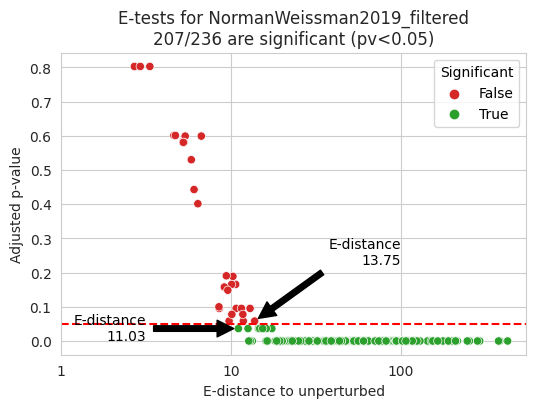

In [36]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, figsize=[6,4], dpi=100)
sns.scatterplot(data=df[df.index!='control'], x='log10_edist', y='pvalue_adj', hue='significant_adj', palette={True: 'tab:green', False: 'tab:red'})

sig = np.sum(df['significant_adj'])
total = len(df)-1  # (removes control)

ax.set_xticks([0,1,2])
# ax.set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])
ax.set_xticklabels([1, 10, 100])
ax.set_title(f'E-tests for {dataset}\n{sig}/{total} are significant (pv<0.05)')
ax.set_ylabel('Adjusted p-value')
ax.set_xlabel('E-distance to unperturbed')
ax.legend(title='Significant')

ax.axhline(0.05, c='r', linestyle='--')
small = df[(df['significant_adj']) & (df.index!='control')].sort_values('edist').iloc[0]
big = df[(~df['significant_adj']) & (df.index!='control')].sort_values('edist').iloc[-1]

ax.annotate(f'E-distance\n{np.round(small.edist,2)}', xy=(small.log10_edist, small.pvalue_adj),  xycoords='data',
            xytext=(0.5, small.pvalue_adj), textcoords='data', fontsize=10,
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='center',
            )

ax.annotate(f'E-distance\n{np.round(big.edist,2)}', xy=(big.log10_edist, big.pvalue_adj),  xycoords='data',
            xytext=(2, big.pvalue_adj+0.2), textcoords='data', fontsize=10,
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='center',
            )

pl.show()

<AxesSubplot:xlabel='log10_edist', ylabel='Density'>

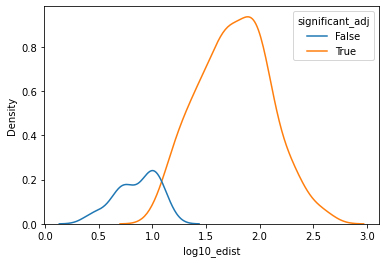

In [4]:
sns.kdeplot(data=df, x='log10_edist', hue='significant_adj')

# E-test example

In [5]:
SDIR = "/fast/scratch/users/peidlis_c/perturbation_resource_paper/"
adata = sc.read(SDIR+f'tmp_data_{dataset}.h5')

In [6]:
top = list(df.sort_values('edist').index[-1:])
N = len(top)

In [7]:
sdata = adata[np.isin(adata.obs.perturbation, top+['control'])].copy()  # bot
sc.pp.pca(sdata, use_highly_variable=False)
sc.pp.neighbors(sdata)
sc.tl.umap(sdata)
sdata.uns['perturbation_colors'] = ['tab:blue', 'tab:grey']

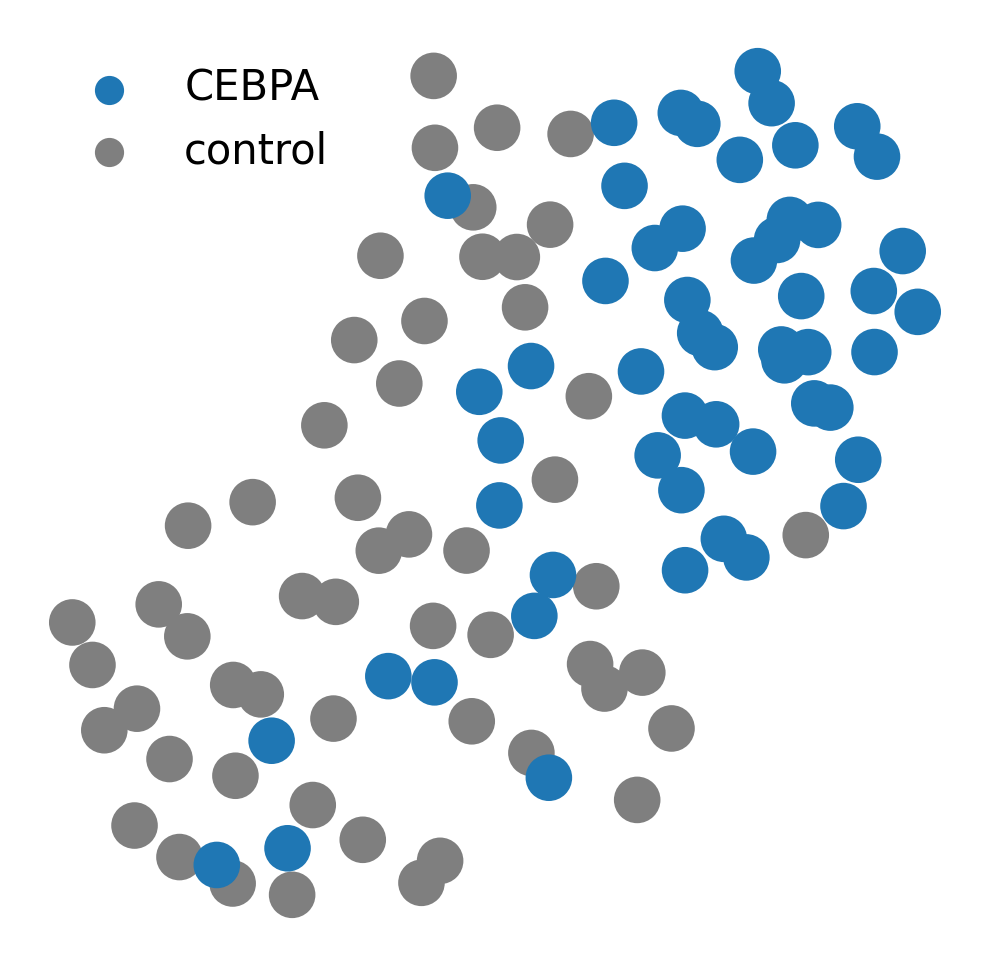

In [9]:
scv.pl.scatter(sdata, color='perturbation', legend_loc='best', figsize=[4,4], show=True, dpi=300, title='', s=500)
pl.show()

In [10]:
df.loc[top]

,edist,pvalue,significant,pvalue_adj,significant_adj,log10_edist
CEBPA,423.792482,0.0,True,0.0,True,2.627153


In [11]:
sdata.obs['temp'] = sdata.obs.perturbation.copy()
np.random.shuffle(sdata.obs['temp'])
sdata.uns['temp_colors'] = ['tab:blue', 'tab:grey']

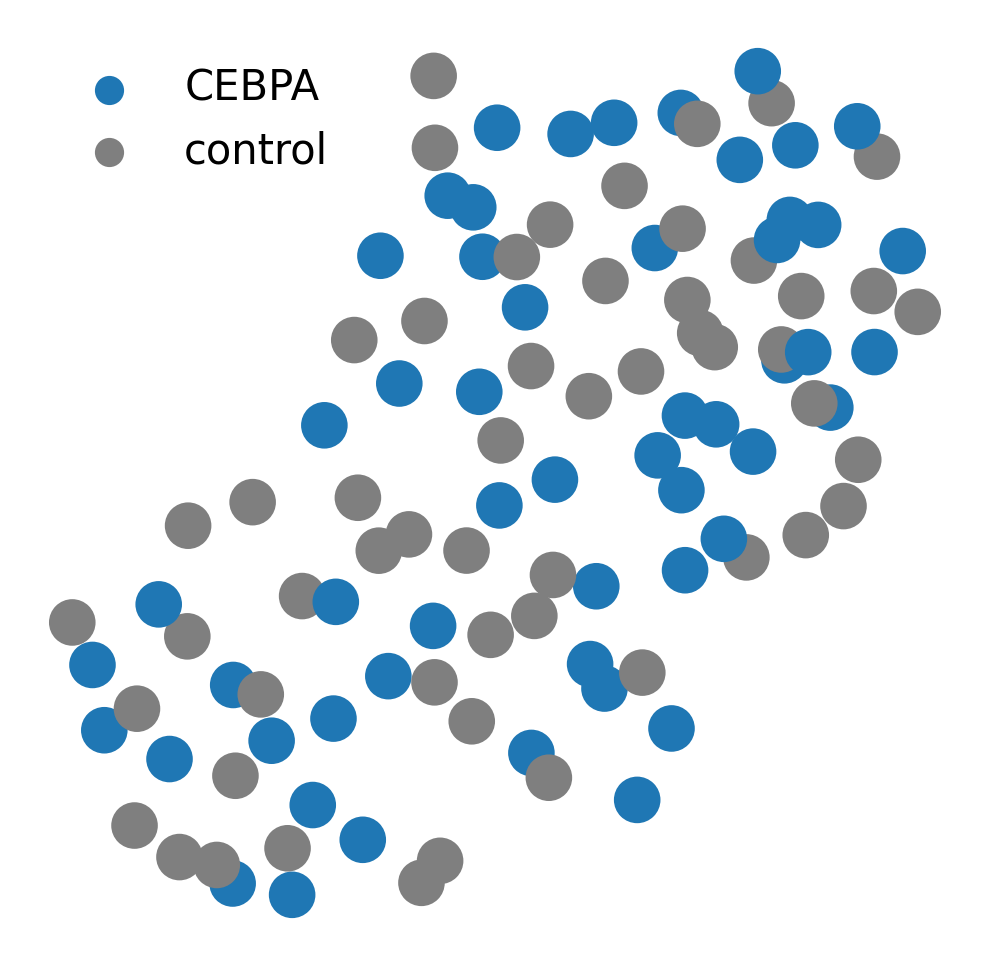

In [12]:
scv.pl.scatter(sdata, color='temp', legend_loc='best', figsize=[4,4], show=True, dpi=300, title='', s=500)
pl.show()

In [184]:
res=[]
for x in tqdm(range(1000)):
    sdata.obs['temp'] = sdata.obs.perturbation.copy()
    np.random.shuffle(sdata.obs['temp'])
    sdata.uns['temp_colors'] = ['tab:blue', 'tab:grey']
    res.append(edist(sdata, 'temp', verbose=False).iloc[0,1])

100%|██████████| 1000/1000 [00:41<00:00, 23.84it/s]


In [ ]:
edist()

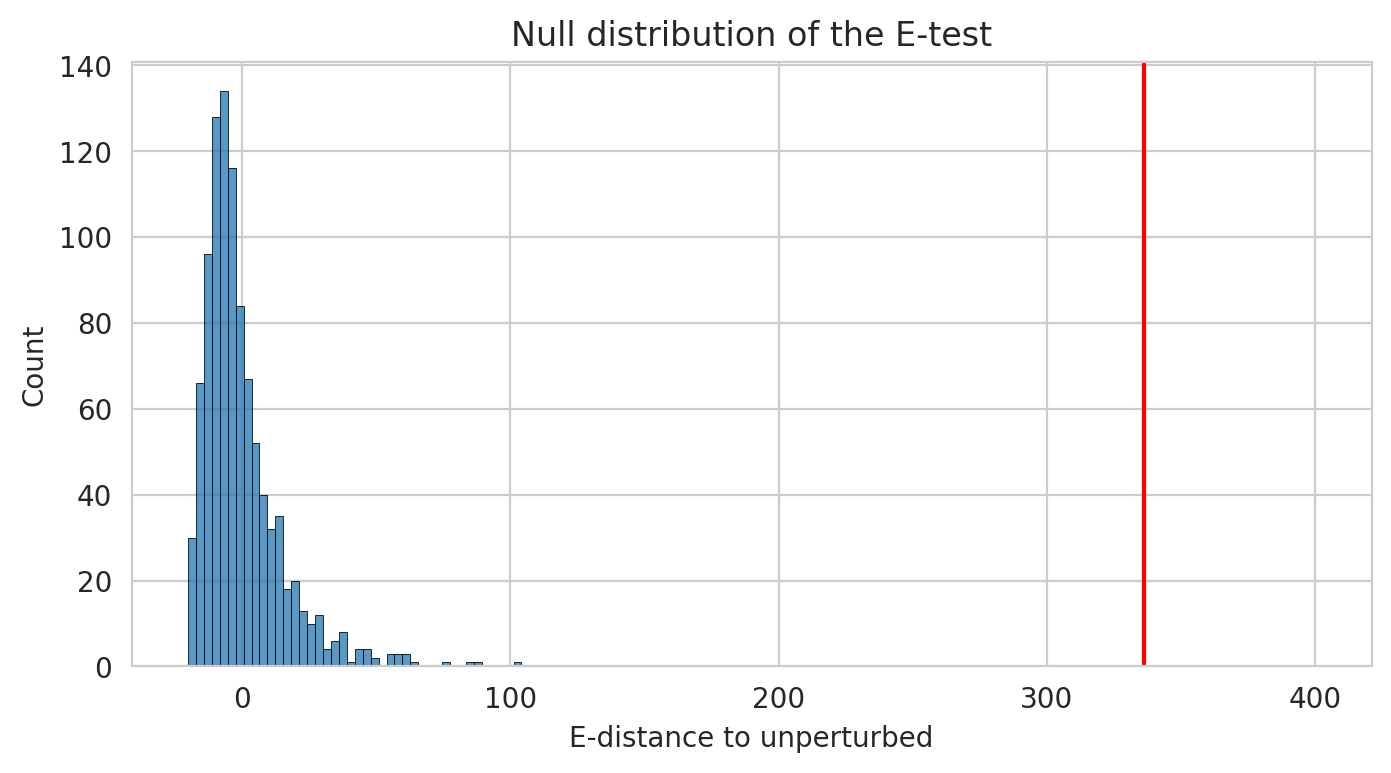

In [196]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[8,4], dpi=200)
sns.histplot(pd.Series(res), binrange=[-20, 400])
ax.set_xlabel('E-distance to unperturbed')
ax.set_title('Null distribution of the E-test')
ax.axvline(336, c='r')
pl.show()

# Fig 3C

In [37]:
indices = list(df.sort_values('edist').index)
N = 3
top=indices[-N:]
bot=indices[:N]

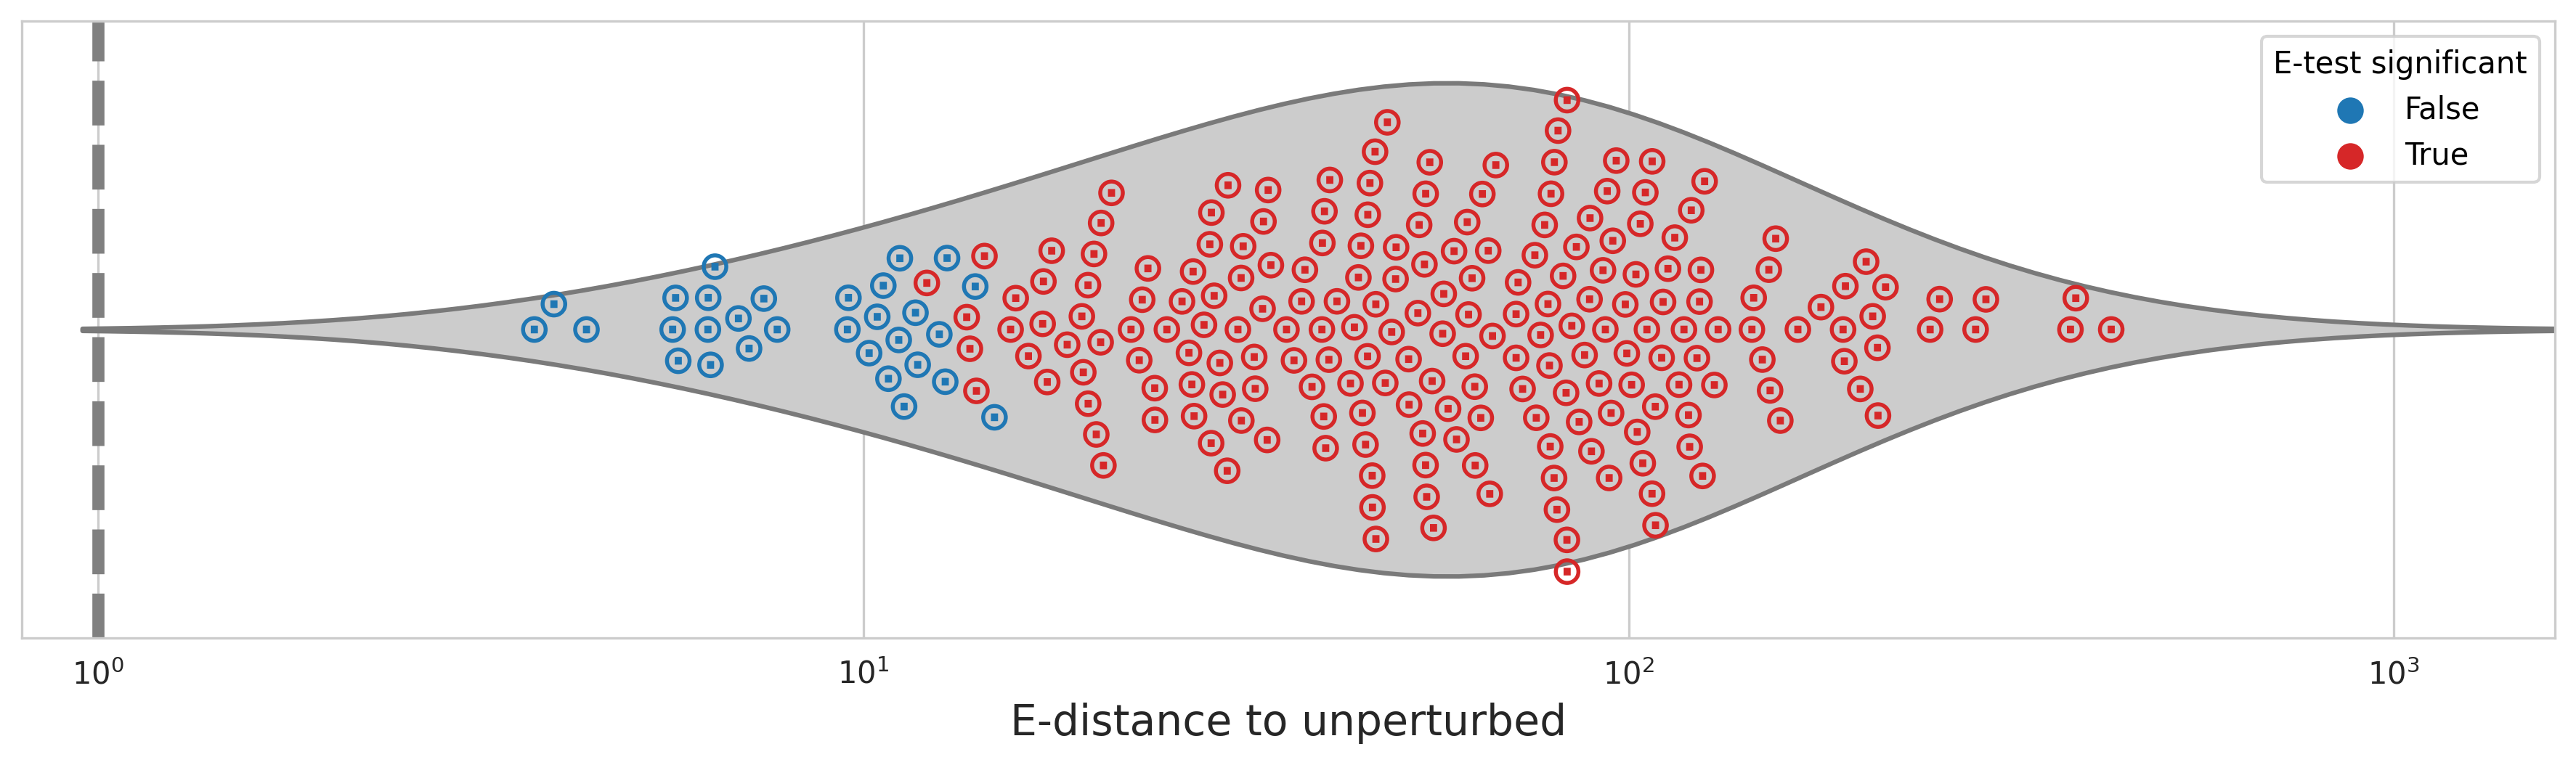

In [39]:
scale=0.75
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20*scale, 5*scale], dpi=300)
df['tmp'] = np.log10(np.clip(df['edist'], 0, np.infty)+1)
# np.log10(estats_control['E-statistic']+1)
sns.violinplot(data=df.drop('control'), x='tmp', inner=None, color=".8", width=0.8, bw=0.7)
ax = sns.swarmplot(data=df.drop('control'), x=df.drop('control')['tmp'], y=['']*len(df.drop('control')), size=10, marker='$\mathbf{\odot}$',
                   edgecolors='white', linewidth=0, hue='significant_adj', palette=['tab:blue', 'tab:red'])
ax.set_xlabel('E-distance to unperturbed', fontsize=14)
ax.axvline(0, c='grey', linestyle='--', linewidth=4)
ax.legend(title='E-test significant')

# log scale x ticks
from matplotlib import ticker as mticker
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
xmin, xmax = ax.get_xlim()
tick_range = np.arange(0, xmax)
ax.xaxis.set_ticks(tick_range)
ax.xaxis.set_ticks([np.log10(x+1) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.set_xlim([-0.1, 3.21])
pl.savefig(figure_path / 'Fig3C.pdf', bbox_inches='tight')
pl.show()